In [48]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)



<module 'dynamic_interval_tools' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/dynamic_interval_tools.py'>

## Notes for Future Features

In [49]:
# TODO: Allowing for custom timestamps to be imported

"""
Apparently the way to do this is: 
    events = np.array([[sample, 0, event_id, timestamp], ...])
where:
    sample: the sample number of the event in the data. This is the position in the data where the event occurs.
    0: this column is usually used as a reserved column in MNE functions, it's not used in this case.
    event_id: an integer that identifies the type of event. This can be used to distinguish different types of triggers, for example, different stimulus conditions, button presses, or other experimental events.
    timestamp: the time in seconds of the event.
"""

"\nApparently the way to do this is: \n    events = np.array([[sample, 0, event_id, timestamp], ...])\nwhere:\n    sample: the sample number of the event in the data. This is the position in the data where the event occurs.\n    0: this column is usually used as a reserved column in MNE functions, it's not used in this case.\n    event_id: an integer that identifies the type of event. This can be used to distinguish different types of triggers, for example, different stimulus conditions, button presses, or other experimental events.\n    timestamp: the time in seconds of the event.\n"

In [50]:
# Tip for using machine learning for exploratory type data analysis

# Use principal component analysis (PCA) or independent component analysis (ICA), 
# to identify patterns in the fNIRS data that are not immediately obvious. 
# This can be used to identify latent neural networks or to identify different sources of signal variation.

# ==========================================================

# I'm curious how we could incorportate these into the data analsyis pipeline

# Anomaly detection
# Unsupervised learning algorithms such as one-class SVM, Autoencoder, and Isolation Forest can be used to identify outliers or abnormal patterns in the data.

# Time-series analysis
# Techniques such as time-series decomposition, ARIMA, and LSTM can be used to analyze the temporal dynamics of the fNIRS data and identify trends or patterns over time.

In [51]:
# Recurring values that we will allow for users to change in the GUI

# Length of the measured interval
interval_length = 15

# Time from trigger point being evaluated
tmin = -1
tmax = 15

# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]

# File path to the folder containing the BIDS data.
root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

# Mock data folder to test pulling meta data from folder structure.
path = "../../LabResearch/IndependentStudy/Data"

# Does the study have variable task lengths or is it consistent?
variable_epoch_time = True


## Find Groups and Subjects from Folder Structure

In [52]:
groups, df = system_file_io.import_data_folder(path, ignore)
df

,group,sub_name,snirf_path
0,anon,sub-06,../../LabResearch/IndependentStudy/Data/anon/s...
1,anon,sub-07,../../LabResearch/IndependentStudy/Data/anon/s...
2,anon,sub-05,../../LabResearch/IndependentStudy/Data/anon/s...
3,direct,sub-01,../../LabResearch/IndependentStudy/Data/direct...
4,direct,sub-02,../../LabResearch/IndependentStudy/Data/direct...
5,direct,sub-04,../../LabResearch/IndependentStudy/Data/direct...


# Loop through subjects for individual analysis

In [53]:
# TODO: Need to loop through this in order to get both groups
group = 'direct'
paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()
print(paths)

['../../LabResearch/IndependentStudy/Data/direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf'
 '../../LabResearch/IndependentStudy/Data/direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf'
 '../../LabResearch/IndependentStudy/Data/direct/sub-04/nirs/sub-04_task-AnonCom_nirs.snirf']


In [54]:
importlib.reload(quality_eval)
# Run a Signal Quality Check

# for path in paths:
    # quality_eval.evaluate_raw_signal(path)
    # quality_eval.evaluate_sci(path)


<module 'quality_eval' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/quality_eval.py'>

In [55]:
# Works for both block and variable interval lengths
all_epochs = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

all_epochs

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
Reading 0 ... 17097  =      0.000 ...  1680.635 secs...


/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/quality_eval.py:60: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


[]
[]
[<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 12.5 sec, baseline -1.25 – 0 sec, ~166 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 12.5 sec, baseline -1.25 – 0 sec, ~166 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 12.5 sec, baseline -1.25 – 0 sec, ~166 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 27.5 sec, baseline -1.25 – 0 sec, ~173 kB, data loaded,

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/quality_eval.py:60: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


[]
[]
[<Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 32.5 sec, baseline -1.25 – 0 sec, ~175 kB, dat

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/quality_eval.py:60: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


[]
[]
[<Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 27.5 sec, baseline -1.25 – 0 sec, ~173 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 27.5 sec, baseline -1.25 – 0 sec, ~173 kB, data loaded,
 'Practice': 2>]
[<Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 27.5 sec, baseline -1.25 – 0 sec, ~173 kB, data loaded,
 'Practice': 2>, <Epochs |  2 events (all good), -1.25 - 33.75 sec, baseline -1.25 – 0 sec, ~175 

defaultdict(list,
            {'Practice': [<Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 12.5 sec, baseline -1.25 – 0 sec, ~166 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 27.5 sec, baseline -1.25 – 0 sec, ~173 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 23.75 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 25 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 32.5 sec, baseline -1.25 – 0 sec, ~175 kB, data loaded,
               'Practice': 2>,
              <Epochs |  2 events (all good), -1.25 - 41.25 sec, baseline -1.25 – 0 sec, ~179 kB, data loaded,
               '

# Extract Evoked Amplitude


In [64]:
importlib.reload(analysis_tools)

df = analysis_tools.extract_average_amplitudes(all_epochs, tmin, tmax)

df

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:210: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.EvokedArray'>.tmax (12.5 sec)
  value = data.crop(tmin=tmin, tmax=tmax).data.mean() * 1.0e6
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:210: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.EvokedArray'>.tmax (12.5 sec)
  value = data.crop(tmin=tmin, tmax=tmax).data.mean() * 1.0e6
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:203: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  data = de

,ID,Chroma,Condition,Value
0,1,hbo,Practice,-8.565129
1,1,hbr,Practice,4.255503
2,2,hbo,Practice,-3.572660
3,2,hbr,Practice,1.795369
4,3,hbo,Practice,4.399917
...,...,...,...,...
67,7,hbr,Neutral,2.842155
68,8,hbo,Neutral,0.731983
69,8,hbr,Neutral,-0.243950
70,9,hbo,Neutral,1.901875


In [69]:
#TODO: This should be fixed to create the DF properly but it's not imperetive to the project.
# more of a nice to have if anything.

# importlib.reload(analysis_tools)
# Returns all measurements taken with each column being a sample taking at a certain time and the rows are a participant hbo or hbr.
# amplitudes = analysis_tools.extract_all_amplitudes(all_epochs, tmin, tmax)
# amplitudes

/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:160: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.EvokedArray'>.tmax (12.5 sec)
  value = data.crop(tmin=tmin, tmax=tmax).data * 1.0e6
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:160: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.evoked.EvokedArray'>.tmax (12.5 sec)
  value = data.crop(tmin=tmin, tmax=tmax).data * 1.0e6
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:154: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  data = deepcopy(subj_da

(72,)


/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:166: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temporal_measurements = np.array(temporal_measurements)


,0
0,"[1.5944946351378264, -1.5944946351378264, 3.27..."
1,"[-1.1622396572075195, 1.1622396572075187, -2.3..."
2,"[-0.6706521351521906, 0.6706521351521906, 5.32..."
3,"[0.4888436062987429, -0.48884360629874374, -3...."
4,"[-11.772132783472587, 11.772132783472587, 28.6..."
...,...
67,"[1.070478437378022, -1.0704784373780223, -2.02..."
68,"[0.08870586643886724, -0.08870586643886745, -0..."
69,"[-0.05213137809996111, 0.05213137809996005, 0...."
70,"[0.47227242423160043, -0.47227242423160004, -0..."


# Statistical Tests

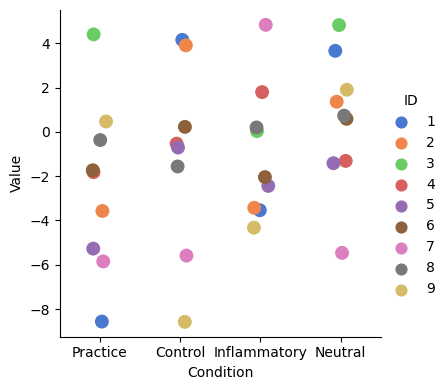

In [70]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)
plt.show()

In [71]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    Value   
No. Observations:    18         Method:                REML    
No. Groups:          9          Scale:                 8.8275  
Min. group size:     2          Log-Likelihood:        -42.9329
Max. group size:     2          Converged:             No      
Mean group size:     2.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.990    1.030 -0.961 0.336 -3.010  1.029
Condition[T.Neutral]  1.531    1.401  1.093 0.274 -1.214  4.277
Group Var             0.727                                    
===============================================================

"""

In [72]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

IndexError: index 17 is out of bounds for axis 0 with size 17

In [73]:
# Control vs Inflam

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

IndexError: index 17 is out of bounds for axis 0 with size 17